In [2]:
!pip install --upgrade pip
%pip install pyrealm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 91.5 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.17.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.1.2 which is incompatible.
cupy-cuda12x 12.2.0 requires

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /drive


In [3]:
!pip install --upgrade 'numpy<2.0' 'pandas==2.0.0'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyrealm
# from pyrealm import pmodel
from pyrealm.splash.splash import SplashModel
from pyrealm.core.calendar import Calendar
import os

site_info = pd.read_csv('/content/drive/MyDrive/pyrealm_demo/fdk_site_info.csv')
## choose site
ds = pd.read_csv('/content/drive/MyDrive/pyrealm_demo/AT-Neu.csv')
# check site name
print(str(ds.sitename.unique()[0]))
## read site inputs
site_temp = ds.loc[:, 'TA_F_MDS'] # daily temperature, unit degree (°C)
site_temp[site_temp < -25] = np.nan
site_swin = ds.loc[:, 'SW_IN_F_MDS']  # shortwave radiation, unit W/m2
site_ppfd = site_swin * (60*60*24) * 2.04 /1000000  # convert to KJ/m2/d then umol/m2/d
site_vpd = ds.loc[:, 'VPD_F_MDS'] * 100  # vpd, unit: hPa converted to Pa
site_co2 = ds.loc[:, 'CO2_F_MDS']  # CO2, unit ppm
site_patm = ds.loc[:, 'PA_F'] * 1000  # site pressure, unit kPa converted to Pa
site_prep = ds.loc[:,'P_F']
site_cld = ds.loc[:, 'CLD']  # cloud cover
site_sunfrac = (100-site_cld)/100 # sun fraction, 0-1
site_fapar = ds.loc[:, 'FPAR']  # fapar

site_lat = site_info.loc[site_info['sitename'] == str(ds.sitename.unique()[0]),'lat']
site_elev = site_info.loc[site_info['sitename'] == str(ds.sitename.unique()[0]),'elv']


  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.17.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
mizani 0.11.4 requires pandas>=2.1.0, but you have pandas 2.0.0 which is incompatible.
plotnine 0.13.6 requires pandas<3.0.0,>=2.1.0, but you have pandas 2.0.0 which is incompatible.
pyrealm 1.0.0 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
xarray 2024.9.0 requires pandas>=2.1, but you have pandas 2.0.0 which is incompatible.
AT-Neu


pyrealm/<ipython-input-3-262b3934b0cc>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
days=np.arange(np.datetime64(ds.loc[0,'TIMESTAMP']),
               np.datetime64(str(int(ds['TIMESTAMP'].iloc[-1][0:4])+1)+'-01-01'),
               np.timedelta64(1, "D"))
splash = SplashModel(
    lat=np.broadcast_to(site_lat, site_sunfrac.shape),
    elv=np.broadcast_to(site_elev, site_sunfrac.shape),
    dates=Calendar(days),
    sf=site_sunfrac.values,
    tc=site_temp.values,
    pn=site_prep.values,
)
init_soil_moisture = splash.estimate_initial_soil_moisture(verbose=True)
# output: aet (actual evapotranspiration), wn (soil volume moisture), ro (run off)
aet_out, wn_out, ro_out = splash.calculate_soil_moisture(init_soil_moisture)
pet_out = splash.evap.pet_d # potential evapotranspiration
alpha = np.mean(aet_out)/np.mean(pet_out)
# calculate relative soil moisture as soil moisture divided by the volume of bucket (150 L)
wn_out_rela = wn_out/150

Iteration: 1; maximum difference: 150.0
Iteration: 2; maximum difference: 0.0


In [5]:
##
!pip install --upgrade numpy
import pyrealm.pmodel
## run P model #########################
## STEP 1: prepare P model environment for leaf level calculation
env = pyrealm.pmodel.PModelEnvironment(tc=site_temp.values,
                        co2=site_co2.values,
                        patm=site_patm.values,
                        vpd=site_vpd.values)
## STEP 2: calculate optimal chi and jmax limiation of C3 and C4 vegetation
model_c3 = pyrealm.pmodel.PModel(env)
# model_c4 = PModel(env, method_optchi='c4')

# STEP 3: scale up for GPP
prod_c3 = model_c3.estimate_productivity(fapar=site_fapar.values,
                                         ppfd=site_ppfd.values)
# prod_c4 = model_c4.estimate_productivity(fapar=site_fapar, ppfd=site_ppfd)
# add soil moisture function
gpp_c3_soilmois = model_c3.gpp * pyrealm.pmodel.functions.calc_soilmstress_stocker(soilm=wn_out_rela,
                                                                    meanalpha=alpha)
# gpp_c4_soilmois = model_c4.gpp * functions.calc_soilmstress_stocker(soilm=site_somois, meanalpha=meanalpha)
# cut-off point of GPP below growing temperature of 0 degree
gpp_c3_soilmois[site_temp.values<0] = 0
# gpp_c4_soilmois[site_temp<0] = 0

ds_result = np.c_[ds, gpp_c3_soilmois]
ds_result_df = pd.DataFrame(ds_result, columns=list(ds)+['mod_gpp'])

  Using cached numpy-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.17.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.1.2 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.2 which is incompatible.
ibis-framework 8.0.0 requires numpy<2,>=1, but you have numpy 2.1.2 which is incompatible.
mizani 0.11.4

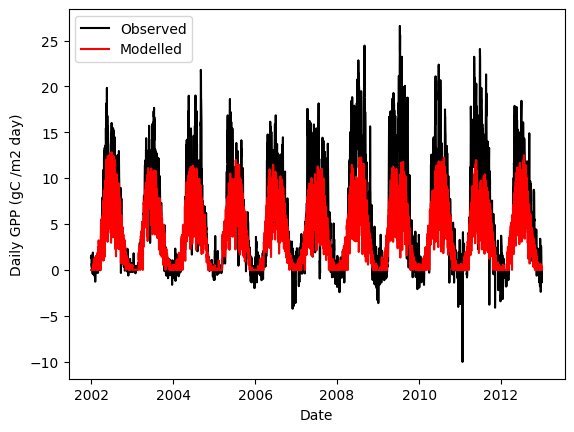

In [ ]:
import matplotlib.pyplot as plt

plt.plot(days, ds_result_df['GPP_NT_VUT_REF'].values, color="black", label="Observed")
plt.plot(days, ds_result_df['mod_gpp'].values,color='red', label="Modelled")
plt.xlabel('Date')
plt.ylabel('Daily GPP (gC /m2 day)')
leg = plt.legend(loc='upper left')

plt.show()